In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

## Data

In [2]:
df_real = pd.read_csv("data/Bouleompiaden _ Statistikdatabasen - Data_ Matcher.csv", encoding="utf-8")\
.rename(columns={
    u"Spelare 1": "p1_name",
    u"Spelare 2": "p2_name",
    u"Poäng 1": "p1_score",
    u"Poäng 2": "p2_score",
    "Turnering": "year",
    u"Nivå": "stage"})\
[["year", "p1_name", "p2_name","p1_score", "p2_score", "stage"]]

df_real["game_id"] = df_real.index
total_score = df_real[["p1_score", "p2_score"]].sum(axis=1)
df_real["diff"] = df_real["p1_score"] - df_real["p2_score"]
df_real["p1_score_share"] = df_real["p1_score"] / total_score
df_real["p2_score_share"] = df_real["p2_score"] / total_score

p1_won = df_real["p1_score"] > df_real["p2_score"]
df_real.loc[p1_won, "winner"] = "p1"
df_real.loc[~p1_won, "winner"] = "p2"
df_real.loc[p1_won, "winner_name"] = df_real.loc[p1_won, "p1_name"]
df_real.loc[~p1_won, "winner_name"] = df_real.loc[~p1_won, "p2_name"]

df_real["winner_points"] = df_real[["p1_score", "p2_score"]].max(axis=1)



is_medal_game = df_real["stage"].isin(["Bronsmatch", "Final"])
df_real.loc[is_medal_game, "score_to_win"] = 12

df_real.loc[is_medal_game, "score_to_win"] = 12
df_real.loc[~is_medal_game, "score_to_win"] = 8

df_real_train = df_real[df_real["year"] != df_real["year"].max()]
df_real_test = df_real[df_real["year"] == df_real["year"].max()]

df_real.head()

,year,p1_name,p2_name,p1_score,p2_score,stage,game_id,diff,p1_score_share,p2_score_share,winner,winner_name,winner_points,score_to_win
0,2011,Jens West,John Kjellkvist,1,7,Gruppspel,0,-6,0.125000,0.875000,p2,John Kjellkvist,7,8.0
1,2011,Cissi Hellman,Andreas Josefson,9,5,Gruppspel,1,4,0.642857,0.357143,p1,Cissi Hellman,9,8.0
2,2011,Theodore Ripman,Calle Sandin,7,4,Gruppspel,2,3,0.636364,0.363636,p1,Theodore Ripman,7,8.0
3,2011,Jakob Lien,Erik Nordenankar,7,6,Gruppspel,3,1,0.538462,0.461538,p1,Jakob Lien,7,8.0
4,2011,Jens West,Olof Sabelström,5,7,Gruppspel,4,-2,0.416667,0.583333,p2,Olof Sabelström,7,8.0


In [3]:
base_cols = ["game_id", "year", "stage", "winner"]
p1_cols = [x for x in df_real.columns if x.startswith("p1")]
p2_cols = [x for x in df_real.columns if x.startswith("p2")]
new_col_names = [x.split("_", 1)[1] for x in p1_cols]
opponent_col_names = [u"opponent_" + x for x in new_col_names]

p1_col_translation = dict(zip(p1_cols + p2_cols, new_col_names + opponent_col_names))
p2_col_translation = dict(zip(p2_cols + p1_cols, new_col_names + opponent_col_names))

df_p1 = df_real[base_cols + p1_cols + p2_cols].rename(columns=p1_col_translation)
df_p2 = df_real[base_cols + p1_cols + p2_cols].rename(columns=p2_col_translation)

df_real_long = pd.concat([df_p1, df_p2], sort=False, axis=0)
df_real_long.head()


,game_id,year,stage,winner,name,score,score_share,opponent_name,opponent_score,opponent_score_share
0,0,2011,Gruppspel,p2,Jens West,1,0.125000,John Kjellkvist,7,0.875000
1,1,2011,Gruppspel,p1,Cissi Hellman,9,0.642857,Andreas Josefson,5,0.357143
2,2,2011,Gruppspel,p1,Theodore Ripman,7,0.636364,Calle Sandin,4,0.363636
3,3,2011,Gruppspel,p1,Jakob Lien,7,0.538462,Erik Nordenankar,6,0.461538
4,4,2011,Gruppspel,p2,Jens West,5,0.416667,Olof Sabelström,7,0.583333


In [4]:
by_player = df_real_long.groupby("name")
df_players = pd.concat([
    by_player["name"].count().rename("n_games"),
    by_player["score_share"].mean()
], axis=1)

df_players.head()



,n_games,score_share
name,,
Agnes1,2,0.000000
Alexander Starfelt,7,0.442641
Andreas Josefson,5,0.418193
Benjamin Ger. Hed.,8,0.524252
Björn Berglund,2,0.461538


In [5]:
df_real_long = df_real_long.merge(df_players["score_share"].rename("opponent_hist_score_share").to_frame(), left_on="opponent_name", right_index=True)

df_players["opponent_score_share"] = df_real_long.groupby("name")["opponent_hist_score_share"].mean()
df_players.sort_values("opponent_score_share")

,n_games,score_share,opponent_score_share
name,,,
Olle Strandberg,3,0.712500,0.353135
John Kjellkvist,3,0.763889,0.355730
Björn Westerfors,2,0.500000,0.373821
Emma1,2,0.358333,0.395595
Maria Adelöf,5,0.407949,0.402973
Patrik Järgården,3,0.672138,0.419661
Simon1,3,0.465741,0.439109
Ylva Ohlson,7,0.515903,0.442324
Richard Ekman,12,0.609567,0.450463


# Modell v. 1: Ren slump

Det första vi måste göra är att skapa en modell för att simulera en enskild spelomgång. Två spelare, tre klot. Spelarna kan få en, två eller tre poäng. Vi kommer att uttrycka resultat av en omång som *skillnanden mellan spelarnas poäng*. `-3.0` betyder att spelare två vunnit med 3-0, `2.0` betyder att spelare ett vunnit med 2-0.

I den här första versionen av modellen antar vi att spelarna är lika bra och att de har 50 procents chans att vinna en omgång. Om vi siumlerar 10 000 spelomgångar skulle resultaten kunna fördela sig så här.

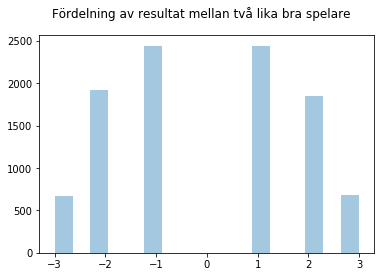

In [176]:
def simulate_round_v1(stdev, n=10000):
    lower, upper = 1, 6 # bounds
    mid = (lower + upper) / 2.0 
    mu = mid # mean
    sigma = stdev
    scores = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(n).round(0)

    scores[scores < mid] = scores[scores < mid] - 4
    scores[scores > mid] = scores[scores > mid] - 3
    
    return scores

scores = simulate_round_v1(2)
sns.distplot(scores, kde=False)
plt.suptitle(u"Fördelning av resultat mellan två lika bra spelare")
plt.show()

Det vi inte vet är hur *bred* den här fördelningen ska vara. Alltså hur vanligt är det att en spelare vinner med 3-0 jämfört med 1-0? Fördelningens bredd styrs av **standardavvikelsen** som jag här bara gissat att är `2`. Men den skulle också kunna vara högra, säg `7`. Då skulle fördelningen se ut så här:

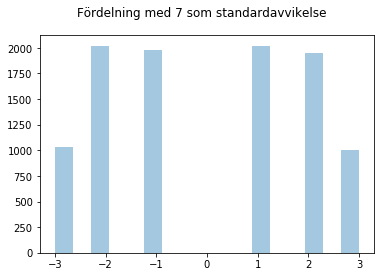

In [177]:
scores = simulate_round_v1(7)
sns.distplot(scores, kde=False)
plt.suptitle(u"Fördelning med 7 som standardavvikelse")
plt.show()

In [6]:
def plot_games(df_games):
    table = pd.pivot_table(df_games, index="p1_score", columns="p2_score", values="winner", aggfunc="count")

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(table, cmap=cmap, vmax=table.max().max(), center=0,
                square=True, linewidths=.5)
    plt.show()

def simulate_game(simulate_round_fn, score_to_win, *args, **kwargs):
    # Simulate rounds: [-1, 1, 3...]
    diffs = simulate_round_fn(*args, **kwargs)

    # Get scores for each player: [0, 1, 3], [1, 0, 0]
    p1_score = np.ma.masked_array(diffs, mask=diffs < 0).filled(fill_value=0)
    p2_score = np.abs(np.ma.masked_array(diffs, mask=diffs > 0)).filled(fill_value=0)

    # Aggregate cumulative score: [[0, 1, 4], [1, 1, 1]]
    score_table = np.cumsum(np.array((p1_score, p2_score)), axis=1)

    # Get the score of the leader after each round
    leading_score = np.max(score_table, axis=0)

    # Get the first round when one player reaches the score needed to win
    win_round = np.argwhere(leading_score >= score_to_win)[0][0]
    p1_score, p2_score = score_table[:, win_round]
    
    return p1_score, p2_score


def evaluate_model(df, model, prepare_fn=None, **kwargs):
    """
    """
    if prepare_fn:
        df = prepare_fn(df)
    
    df_sim = df.apply(model, axis=1, **kwargs)
    p1_wins = df_sim["p1_win_prob"] > df_sim["p2_win_prob"]
    df_sim.loc[p1_wins, "prob_winner"] = "p1"
    df_sim.loc[~p1_wins, "prob_winner"] = "p2"
    df = pd.concat([df, df_sim], axis=1)

    df["correct_winner"] = df["winner"] == df["prob_winner"]
    summary = pd.Series()
    summary["diff_error"] = (df["diff"] - df["sim_mean_diff"]).abs().mean() 
    summary["most_common_diff"] = (df["diff"] - df["sim_most_common_diff"]).abs().mean() 
    summary["correct_winner"] = df["correct_winner"].sum() / float(df["correct_winner"].count())
    
    return summary, df

def simulate_many_games(n_games, simulate_round_fn, score_to_win, *args, **kwargs):
    scores = map(lambda i: simulate_game(simulate_round_fn, score_to_win,
                                       *args, **kwargs), range(n_games))
    df_games = pd.DataFrame(scores)
    df_games.columns = ["p1_score", "p2_score"]
    p1_wins = df_games["p1_score"] > df_games["p2_score"]
    #df_games.loc[p1_wins, "winner"] = "p1"
    #df_games.loc[~p1_wins, "winner"] = "p2"
    
    meta = pd.Series()
    meta["p1_wins"] = df_games[p1_wins].shape[0]
    meta["p2_wins"] = df_games[~p1_wins].shape[0]
    meta["p1_win_prob"] = meta["p1_wins"] / float(n_games)
    meta["p2_win_prob"] = meta["p2_wins"] / float(n_games)
    diff = df_games["p1_score"] - df_games["p2_score"]
    meta["sim_mean_diff"] = diff.mean()
    meta["sim_mean_diff_abs"] = np.abs(diff.mean())
    meta["sim_most_common_diff"] = diff.mode().iloc[0]
    meta["scores"] = scores

    return meta

def score_string(df, p1_col="p1_score", p2_col="p2_score"):
    """Make a string with the winning score always first 
    """
    winner_score = df[[p1_col, p2_col]].max(axis=1)
    loser_score = df[[p1_col, p2_col]].min(axis=1)
    return winner_score.astype(int).astype(str) + "-" + loser_score.astype(int).astype(str)
#simulate_many_games(1000, simulate_round_v2, 8, 0.1, 0.9, skill_factor=5)    
    


Den här funktionen för att simulera enskild omgångar kommer vara kärnan i modellen. För att simulera en match låter vi funktionen slumpa fram omgångsresultat till någon av spelarna når 8 poäng (eller en högre gräns om vi så vill - `SCORE_TO_WIN`).

In [181]:
SCORE_TO_WIN = 8
for i in range(10):
    p1_score, p2_score = simulate_game(simulate_round_v1, SCORE_TO_WIN, stdev=5)
    print "Simulerat resultat: {}-{}".format(p1_score.astype(int), p2_score.astype(int))

Simulerat resultat: 5-8
Simulerat resultat: 9-5
Simulerat resultat: 8-7
Simulerat resultat: 6-8
Simulerat resultat: 1-9
Simulerat resultat: 5-8
Simulerat resultat: 8-7
Simulerat resultat: 8-0
Simulerat resultat: 6-9
Simulerat resultat: 8-3


Vi vet fortfarande inte vilken den korrekta standardavvikelsen för en enskild omgång är. För att göra en kvalificerad bedömning av det ska vi nu simulera en massa matcher med olika standardavvikelser och jämföra fördelningen av resultat mot verkliga, historiska resultat. Vilken standardavvikelse producerar med realistiska slutresultat? 

In [32]:
dfs = []
for stdev in range(1,20):
    stdev = stdev / 2.0
    res = simulate_many_games(5000, simulate_round_v1, score_to_win=8, stdev=stdev)
    df = pd.DataFrame(res["scores"], columns=["p1_score", "p2_score"])
    df["stdev"] = stdev
    dfs.append(df)
df_games = pd.concat(dfs)
df_games["score"] = score_string(df_games)
df_games.head()

,p1_score,p2_score,stdev,score
0,6.0,8.0,0.5,8-6
1,3.0,8.0,0.5,8-3
2,8.0,5.0,0.5,8-5
3,6.0,8.0,0.5,8-6
4,6.0,8.0,0.5,8-6


In [33]:
score_table = pd.pivot_table(df_games, index="score", columns="stdev", values="p1_score", aggfunc="count")
score_table = score_table / score_table.sum()
score_table.head()

stdev,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5
score,,,,,,,,,,,,,,,,,,,
10-0,NaN,0.0010,0.0018,0.0054,0.0048,0.0042,0.0084,0.0078,0.0058,0.0062,0.0070,0.0104,0.0052,0.0078,0.0054,0.0072,0.0066,0.0082,0.0082
10-1,NaN,0.0014,0.0056,0.0038,0.0080,0.0072,0.0060,0.0074,0.0062,0.0044,0.0076,0.0098,0.0086,0.0072,0.0056,0.0048,0.0068,0.0066,0.0086
10-2,NaN,0.0030,0.0060,0.0126,0.0080,0.0130,0.0098,0.0098,0.0096,0.0132,0.0108,0.0116,0.0122,0.0116,0.0110,0.0120,0.0106,0.0122,0.0114
10-3,NaN,0.0038,0.0072,0.0074,0.0112,0.0112,0.0128,0.0110,0.0126,0.0124,0.0144,0.0154,0.0154,0.0150,0.0122,0.0168,0.0122,0.0146,0.0136
10-4,NaN,0.0046,0.0088,0.0100,0.0118,0.0138,0.0168,0.0142,0.0140,0.0122,0.0134,0.0146,0.0118,0.0144,0.0114,0.0148,0.0124,0.0152,0.0152


In [183]:
print u"Vilka är de vanligaste RIKTIGA resultaten?"
real_scores = score_string(df_real[["p1_score", "p2_score"]]).value_counts()
# Filtrerar bort semifinaler och finaler med högre resultat
real_scores = real_scores[real_scores.index.isin(score_table.index)]
real_scores = real_scores / real_scores.sum()
(real_scores * 100).round(1)

Vilka är de vanligaste riktiga resultaten?


9-6     9.3
8-4     9.3
8-3     8.1
9-4     7.0
9-2     7.0
9-1     7.0
8-0     7.0
8-6     5.8
8-1     5.8
9-5     4.7
9-7     4.7
10-3    4.7
8-5     4.7
8-2     3.5
9-3     3.5
9-0     3.5
10-7    1.2
10-1    1.2
10-2    1.2
10-5    1.2
dtype: float64

In [188]:
print u"Hur många procentenheter diffar resultatfördelning vid olika standardavvikelser?"
(score_table.subtract(real_scores, axis=0).abs().mean().iloc[2:] * 100).round(2)

Hur många procentenheter diffar resultatfördelning vid olika standardavvikelser?


stdev
1.5    2.21
2.0    1.96
2.5    1.93
3.0    1.76
3.5    1.79
4.0    1.79
4.5    1.79
5.0    1.81
5.5    1.62
6.0    1.73
6.5    1.74
7.0    1.73
7.5    1.86
8.0    1.77
8.5    1.70
9.0    1.80
9.5    1.74
dtype: float64

Slutsatsen vi kan dra här är att vi får de mest realistiska slutresultaten vid med en standardavvikelse på ca `5.5`. Visualiserat innebär det en resultaten i en typisk omgång i Boulimpiaden fördelar sig så här:

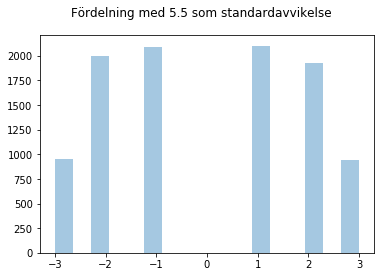

In [190]:
scores = simulate_round_v1(5.5)
sns.distplot(scores, kde=False)
plt.suptitle(u"Fördelning med 5.5 som standardavvikelse")
plt.show()

För att utvärdera vår statistiska modell kommer vi att köra den på 2018 års data för att se hur väl den predicerar resultat. Vi gör det så här:

- Vi simulerar varje match ett visst antal gånger.
- Vi kollar hur ofta det simulerade resultatet ger rätt vinnare.
- Vi kollar hur mycket de simulerade resultatet diffar från det riktiga resultatet.

Den första versionen av modellen kommer alltså utgå från att utgången i en enskild omgång (och förlängningen en enskild match) är helt slumpmässig. Vi kan alltså förvänta oss att den förutser rätt vinnare ungefär hälften av gångerna.

In [206]:
def describe_evaluation(summary, df):
    n_games=len(df.iloc[0]["scores"])
    print u"""
    Antal simuleringar per match: {n_games}
    Korrekt vinnare: {n_correct_winner}/{n_games} gånger ({correct_winner_pct} %)
    Medelfel på resultat: {mean_error} 
    """.format(
    n_games=n_games,
    n_correct_winner=np.round(summary["correct_winner"] * n_games) ,
    correct_winner_pct=np.round(summary["correct_winner"] * 100, 0),    
    mean_error=np.round(summary["diff_error"], 1)            
    )

In [8]:
ROUND_SCORE_STD = 5.5

In [207]:
def modelV1(row):
    return simulate_many_games(1000, simulate_round_v1, row["score_to_win"], stdev=ROUND_SCORE_STD)


summary, df = evaluate_model(df_real_train, modelV1)
describe_evaluation(summary, df)


    Antal simuleringar per match: 1000
    Korrekt vinnare: 521.0/1000 gånger (52.0 %)
    Medelfel på resultat: 4.3 
    


Mycket riktigt. Med slumpen som utgångspunkt träffar modellen rätt vinnare i ungefär hälften av alla matcher.

# Modell v. 2: Vi introducerar `skill`

Utgången i en match är så klart aldrig 50-50. Baserat på tidigare års resultat kan vi ha en föraning om hur bra alla spelare är. Version 2 av modellen tar detta i beaktande.

Vi introducerar en `skill` för varje spelare, ett värde mellan `0` och `1` där den bästa spelaren får `1` och den sämsta `0`. När vi nu simulerar en omgång kommer den förväntad resultatfördeling förskjutas till höger om spelare ett är bättre, och till vänster om spelare 2 är bättre.

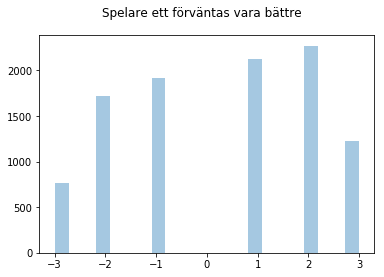

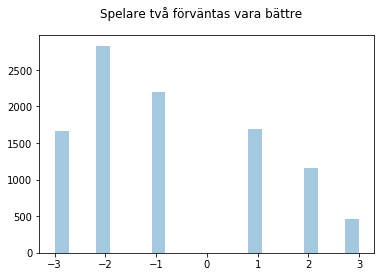

In [209]:

def simulate_round_v2(p1_skill, p2_skill, skill_factor=3, stdev=ROUND_SCORE_STD, n=10000):
    assert p1_skill <= 1 and p1_skill >= 0 
    assert p2_skill <= 1 and p2_skill >= 0 
    
    lower, upper = 0, 5 # bounds
    mid = (lower + upper) / 2.0 
    mu = mid * (p1_skill - p2_skill) * skill_factor
    sigma = stdev
    scores = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(n).round(0)

    scores[scores < mid] = scores[scores < mid] - 3
    scores[scores > mid] = scores[scores > mid] - 2
    
    return scores

scores1 = simulate_round_v2(0.6, 0.4, skill_factor=12)
scores2 = simulate_round_v2(0.4, 0.6, skill_factor=12)

sns.distplot(scores1, kde=False)
plt.suptitle(u"Spelare ett förväntas vara bättre")
plt.show()

sns.distplot(scores2, kde=False)
plt.suptitle(u"Spelare två förväntas vara bättre")
plt.show()


I den första grafen har spelare 1 `0.6` i `skill`, spelare 2 `0.4`. Vi ser då att det troligaste utfallet är att spelare ett vinner en omgång med 2-0, men att det också inträffar att spelare två vinner till och med 3-0.


In [12]:
def modelV2(row, **kwargs):
    STDEV = ROUND_SCORE_STD
    skill_factor = kwargs["skill_factor"]
    return simulate_many_games(1000, simulate_round_v2, row["score_to_win"],
                                       row["p1_skill"], row["p2_skill"],
                                       skill_factor=skill_factor,
                                       stdev=STDEV)




def prepare_modelV2(df):
    df = df.merge(df_players["score_share"].rename("p1_hist_score_share").to_frame(), how="left", left_on="p1_name", right_index=True)    
    df = df.merge(df_players["score_share"].rename("p2_hist_score_share").to_frame(), how="left", left_on="p2_name", right_index=True)    
    best_score_share =  df_players["score_share"].max()
    df["p1_skill"] = df["p1_hist_score_share"] /  best_score_share
    df["p2_skill"] = df["p2_hist_score_share"] / best_score_share

    df.loc[df["p1_skill"].isna(), "p1_skill"] = 0.5
    df.loc[df["p2_skill"].isna(), "p2_skill"] = 0.5
    
    return df

Variabeln `skill` räknar baserar vi på varje spelares **andel poäng per match**, historiskt sett. Vi normaliserar det här värdet så att den spelare med högst, historisk andel poäng per match får `1.0` i skill, och den med lägst `0.0`.


In [218]:
print "Spelarna med högst andel poäng per match"
print df_players.sort_values("score_share", ascending=False)[["n_games", "score_share"]].head(10)

print "\n\nSpelarna med lägst andel poäng per match"
print df_players.sort_values("score_share", ascending=True)[["n_games", "score_share"]].head(10)

Spelarna med högst andel poäng per match
                     n_games  score_share
name                                     
John Kjellkvist            3     0.763889
Estrid                     5     0.720582
Olle Strandberg            3     0.712500
Erik Nordenankar          24     0.710451
Johan Alm                  5     0.675748
Patrik Järgården           3     0.672138
Gabriel Nordenankar       20     0.650749
Filip Tydén                5     0.646183
Charlotte Johansson        4     0.642045
Daniel Mensak              5     0.630714


Spelarna med lägst andel poäng per match
                     n_games  score_share
name                                     
Agnes1                     2     0.000000
Conny Åberg                2     0.150000
Sofia Söderberg            2     0.150000
Karl1                      2     0.173611
Olga                       2     0.200000
Linn Enhage                5     0.225000
Petter Hammarbäck          2     0.244318
Kajsa Hallberg-Nor.        4     0

Det vi _inte_ veta är hur exakt hur stor vikt vi ska sätta vid den här `skill`-variabeln. Hur mycket förväntas den påverka resultatet? Vi kallar den här faktorn för `skill_factor`. Vi kan nu testa modellen med olika `skill_factor` för att se vilken som ger bäst resultat.



In [233]:
summaries_v2 = []
eval_dfs_v2 = []
for skill_factor_base in range(1,10):
    skill_factor = skill_factor_base * 1.5
    print "Testkör modell v2 med {} som skill_factor".format(skill_factor)
    summary, df_eval = evaluate_model(df_real_test, modelV2, prepare_fn=prepare_modelV2, skill_factor=skill_factor)
    summary["skill_factor"] = skill_factor
    df_eval["skill_factor"] = skill_factor
    summaries_v2.append(summary)
    eval_dfs_v2.append(df_eval)



Testkör modell v2 med 1.5 som skill_factor
Testkör modell v2 med 3.0 som skill_factor
Testkör modell v2 med 4.5 som skill_factor
Testkör modell v2 med 6.0 som skill_factor
Testkör modell v2 med 7.5 som skill_factor
Testkör modell v2 med 9.0 som skill_factor
Testkör modell v2 med 10.5 som skill_factor
Testkör modell v2 med 12.0 som skill_factor
Testkör modell v2 med 13.5 som skill_factor


In [234]:
df_eval_v2 = pd.concat(summaries_v2, axis=1).T.set_index("skill_factor")
df_eval_v2.round(2)

,diff_error,most_common_diff,correct_winner
skill_factor,,,
1.5,4.06,5.33,0.46
3.0,3.81,4.83,0.55
4.5,3.57,4.20,0.63
6.0,3.39,4.02,0.69
7.5,3.25,3.90,0.71
9.0,3.13,3.65,0.73
10.5,3.04,3.89,0.72
12.0,3.05,4.00,0.72
13.5,3.05,4.15,0.72


# Modell v. 3: Vi tar motståndarnas nivå i beaktande

Ett potentiellt problem med vårt nuvarande sätt att räkna ut spelarnas `skill` är att vi inte beaktar motståndarnas nivå. En spelare som gjort tre matcher och vunnit samtliga kanske har haft väldigt lätt motstånd.

Vår version 3 av modellen försöker beakta detta genom att justera `skill`-nivän för alla spelare genom att mutliplicera med de historiska motståndarnas medel-`skill`. Om man spelat mot endast toppspelare kommer `skill`-nivån att skrivas upp, och tvärtom om man spelare mot bottenspelare.

In [43]:
modelV3 = modelV2

def prepare_modelV3(df):
    ss = df_players["score_share"]
    df = df.merge(ss.rename("p1_hist_score_share").to_frame(), how="left", left_on="p1_name", right_index=True)    
    df = df.merge(ss.rename("p2_hist_score_share").to_frame(), how="left", left_on="p2_name", right_index=True)    

    oss = df_players["opponent_score_share"]
    df = df.merge(oss.rename("p1_opponent_hist_score_share").to_frame(), how="left", left_on="p1_name", right_index=True)    
    df = df.merge(oss.rename("p2_opponent_hist_score_share").to_frame(), how="left", left_on="p2_name", right_index=True)    

    best_score_share =  df_players["score_share"].max()

    df["p1_opponent_skill"] = df["p1_opponent_hist_score_share"] /  best_score_share
    df["p2_opponent_skill"] = df["p2_opponent_hist_score_share"] / best_score_share


    df["p1_skill"] = df["p1_hist_score_share"] /  best_score_share * (df["p1_opponent_skill"] / 0.5)
    df["p2_skill"] = df["p2_hist_score_share"] / best_score_share * (df["p2_opponent_skill"] / 0.5)

    best_skill = df[["p1_skill","p2_skill"]].max().max()
    worst_skill = df[["p1_skill","p2_skill"]].min().min()

    df["p1_skill"] = (df["p1_skill"] - worst_skill) / (best_skill - worst_skill)
    df["p2_skill"] = (df["p2_skill"] - worst_skill) / (best_skill - worst_skill)

    df.loc[df["p1_skill"].isna(), "p1_skill"] = 0.5
    df.loc[df["p2_skill"].isna(), "p2_skill"] = 0.5
    
    return df

In [228]:
summaries = []
eval_dfs = []
for skill_factor_base in range(1,10):
    skill_factor = skill_factor_base * 1.5
    print "Testkör modell v3 med {} som skill_factor".format(skill_factor)
    summary, df_eval = evaluate_model(df_real_test, modelV3, prepare_fn=prepare_modelV3, skill_factor=skill_factor)
    summary["skill_factor"] = skill_factor
    df_eval["skill_factor"] = skill_factor
    summaries.append(summary)
    eval_dfs.append(df_eval)

#

Testkör modell v3 med 1.5 som skill_factor
Testkör modell v3 med 3.0 som skill_factor
Testkör modell v3 med 4.5 som skill_factor
Testkör modell v3 med 6.0 som skill_factor
Testkör modell v3 med 7.5 som skill_factor
Testkör modell v3 med 9.0 som skill_factor
Testkör modell v3 med 10.5 som skill_factor
Testkör modell v3 med 12.0 som skill_factor
Testkör modell v3 med 13.5 som skill_factor


In [232]:
df_eval_v3 = pd.concat(summaries, axis=1).T.set_index("skill_factor")
df_eval_v3.round(2)

,diff_error,most_common_diff,correct_winner
skill_factor,,,
1.5,4.07,5.39,0.46
3.0,3.80,4.82,0.52
4.5,3.57,3.97,0.63
6.0,3.35,3.87,0.69
7.5,3.14,3.47,0.76
9.0,3.00,3.47,0.79
10.5,2.91,3.48,0.77
12.0,2.81,3.49,0.78
13.5,2.80,3.76,0.75


# Model v4: Osäkerhet i nivåbestämning


En svaghet med version 3 av modellen är att den utgår från att vi är säkra på hur bra alla spelare är. Nu gissar vi att ny spelare är medelbra (`skill=0.5`), men vi skulle hellre vilja säga att vi *tror* att den nya spelaren är `0.5` bra, men att det också *kan* vara en stjärna, eller en rookie. Vi vill med andra ord uttrycka spelaren `skill` som en fördelning, snarare än en punktskattning. Så här: 

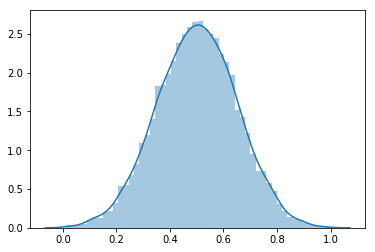

In [115]:
skill = truncated_norm_distribution(0.5, 0.15, 0, 1, 10000)
sns.distplot(skill)


Här är `0.5` fördelningens mitt, och `0.15` standardavvikelsen, det vill säga ett mått på spridningen.

Om vi däremot har en annan spelare som varit med tidigare kan vi vara mer säkra på vilken nivå hen ligger på. Säg att en ny spelare möter en spelare som varit med flera år och fått en `skill`-poäng på `0.7` och vi känner att vi blivit ganska säkra på hur bra hen är (standardavvikelse=`0.05`). Då skulle vi kunna uttrycka spelarnas förväntade `skill` så här:

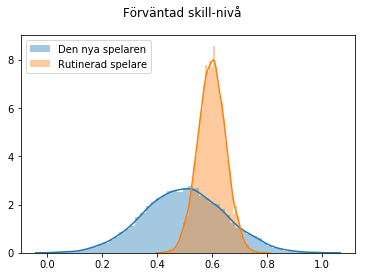

In [48]:
p1_skill = truncated_norm_distribution(0.5, 0.15, 0, 1, 10000)
p2_skill = truncated_norm_distribution(0.6, 0.05, 0, 1, 10000)
ax=sns.distplot(p1_skill, label="Den nya spelaren")
sns.distplot(p2_skill, label="Rutinerad spelare")
ax.legend(loc="upper left")
plt.suptitle(u"Förväntad skill-nivå")
plt.show()

Den här grafen kan vi tolka så här: Det *troliga* är att den rutinerade spelaren är bättre, men vi vet inte säkert. Det finns också en liten chans att den nya spelaren är superbra och har en `skill` på närmare `1.0`. 

Exakt hur brett det här spannet ska vara vet vi inte. Just nu sätter vi bara några godtyckliga gränser för minimi- och maximinivå av osäkerhet (`MIN_STD` och `MAX_STD` i koden nedan). Och vi gör ett antagande om att vi blir gradvis säkrare på en spelares nivå, ju fler matcher hen har spelat upp till ett visst tak (`N_GAME_CAP`).

Detta här är version 4 av vår modell:

In [9]:
def simulate_round_v4(p1_skill, p2_skill, skill_factor=3, stdev=ROUND_SCORE_STD, n=10000):
    if not isinstance(p1_skill, float):
        p1_skill = np.random.choice(p1_skill)

    if not isinstance(p2_skill, float):
        p2_skill = np.random.choice(p2_skill)

    assert p1_skill <= 1 and p1_skill >= 0 
    assert p2_skill <= 1 and p2_skill >= 0 
    
    lower, upper = 0, 5 # bounds
    mid = (lower + upper) / 2.0 
    mu = mid * (p1_skill - p2_skill) * skill_factor
    sigma = stdev
    scores = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(n).round(0)

    scores[scores < mid] = scores[scores < mid] - 3
    scores[scores > mid] = scores[scores > mid] - 2
    
    return scores

def prepare_modelV4(df):
    df = prepare_modelV3(df)

    n_games = df_players["n_games"]
    df = df.merge(n_games.rename("p1_n_games").to_frame(), how="left", left_on="p1_name", right_index=True)    
    df = df.merge(n_games.rename("p2_n_games").to_frame(), how="left", left_on="p2_name", right_index=True)    
    MIN_STD = 0.05 # alla antas ha minst denna osäkerhet
    MAX_STD = 0.15 # högsta osäkerhet
    N_GAME_CAP = 10.0 # Har spelaren gjort så här många matcher får den max osäkerhet
    df["p1_skill_uncertainty"] = MIN_STD + (1 - df["p1_n_games"].clip_upper(N_GAME_CAP) / N_GAME_CAP) * (MAX_STD - MIN_STD)
    df["p2_skill_uncertainty"] = MIN_STD + (1 - df["p2_n_games"].clip_upper(N_GAME_CAP) / N_GAME_CAP) * (MAX_STD - MIN_STD)

    df.loc[df["p1_skill_uncertainty"].isna(), "p1_skill_uncertainty"] = MAX_STD
    df.loc[df["p2_skill_uncertainty"].isna(), "p2_skill_uncertainty"] = MAX_STD
    
    return df

def modelV4(row, **kwargs):
    skill_factor = kwargs["skill_factor"]
    p1_skill = truncated_norm_distribution(row["p1_skill"], row["p1_skill_uncertainty"], 0, 1, 1000)
    p2_skill = truncated_norm_distribution(row["p2_skill"], row["p2_skill_uncertainty"], 0, 1, 1000)
    return simulate_many_games(1000, simulate_round_v4, row["score_to_win"],
                                       p1_skill, p2_skill,
                                       skill_factor=skill_factor,
                                       stdev=ROUND_SCORE_STD)


def truncated_norm_distribution(mu, sigma, lower, upper, n):
    return stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma).rvs(n)

Och så här kan det se ut om vi simulerar 1000 matcher mellan två spelare med hjälp modellen och jämför det mot det faktiska utfallet.

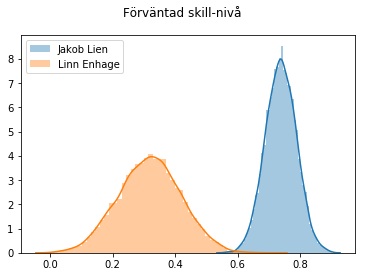


Match: Jakob Lien vs Linn Enhage (2018)

Skill, Jakob Lien: 0.74
Skill, Linn Enhage: 0.32

Osäkerhet på skill, Jakob Lien: 0.05
Osäkerhet på skill, Linn Enhage: 0.1

Vinstchans, Jakob Lien: 93.2 %
Vinstchans, Linn Enhage: 6.8 %

Förväntat vinstmarginal: 8.0 poäng

Faktiskt resultat: 4-7




In [38]:
df = prepare_modelV4(df_real_test).head(5)
res = df.apply(modelV4, skill_factor=15, axis=1)

row = df.iloc[4]
res_row = res.iloc[4]

p1_skill = truncated_norm_distribution(row.p1_skill, row.p1_skill_uncertainty, 0, 1, 10000)
p2_skill = truncated_norm_distribution(row.p2_skill, row.p2_skill_uncertainty, 0, 1, 10000)

ax=sns.distplot(p1_skill, label=row.p1_name)
sns.distplot(p2_skill, label=row.p2_name)
ax.legend(loc="upper left")
plt.suptitle(u"Förväntad skill-nivå")
plt.show()

print """
Match: {p1_name} vs {p2_name} ({year})

Skill, {p1_name}: {p1_skill}
Skill, {p2_name}: {p2_skill}

Osäkerhet på skill, {p1_name}: {p1_uncertainty}
Osäkerhet på skill, {p2_name}: {p2_uncertainty}

Vinstchans, {p1_name}: {p1_win_prob} %
Vinstchans, {p2_name}: {p2_win_prob} %

Förväntat vinstmarginal: {most_common_diff} poäng

Faktiskt resultat: {p1_score}-{p2_score}

""".format(p1_name=row.p1_name, p2_name=row.p2_name, year=row.year, p1_skill=row.p1_skill.round(2),
           p2_skill=row.p2_skill.round(2), p1_win_prob=res_row.p1_win_prob * 100, 
           p2_win_prob=res_row.p2_win_prob * 100, most_common_diff=res_row.sim_most_common_diff,
          p1_uncertainty=row.p1_skill_uncertainty, p2_uncertainty=row.p2_skill_uncertainty,
          p1_score=row.p1_score, p2_score=row.p2_score)



In [ ]:

summaries_v4 = []
eval_dfs_v4 = []
for skill_factor_base in range(1,15):
    skill_factor = skill_factor_base * 1.5
    print skill_factor
    summary, df_eval = evaluate_model(df_real_test, modelV4, prepare_fn=prepare_modelV4, skill_factor=skill_factor)
    summary["skill_factor"] = skill_factor
    df_eval["skill_factor"] = skill_factor
    summaries_v4.append(summary)
    eval_dfs_v4.append(df_eval)

#


1.5
3.0


In [39]:
pd.concat(summaries_v4, axis=1).T.set_index("skill_factor").round(2)

NameError: name 'summaries' is not defined

In [112]:
_df= df_eval[df_eval.skill_factor == 10.5]
sim_scores = []
for s in _df["scores"]:
    sim_scores += s

df_sim_games = pd.DataFrame(sim_scores, columns=["p1_score", "p2_score"])
df_sim_games.head()

,p1_score,p2_score
0,2.0,8.0
1,8.0,1.0
2,6.0,9.0
3,0.0,8.0
4,9.0,3.0


In [113]:


sim_scores = score_string(df_sim_games).value_counts()
sim_scores = sim_scores / sim_scores.sum()

real_scores = score_string(df_real).value_counts()
real_scores = real_scores[real_scores.index.isin(sim_scores.index)]
real_scores = real_scores / real_scores.sum()

table = pd.concat([
    sim_scores.rename("sim_score"),
    real_scores.rename("real_score"),
], axis=1, sort=False)
table["diff"] = table.sim_score - table.real_score
(table * 100).round(1).sort_values("diff")

,sim_score,real_score,diff
9-6,3.5,8.5,-5.1
9-1,3.5,6.4,-2.9
10-3,1.6,4.3,-2.6
9-4,4.1,6.4,-2.3
8-4,6.6,8.5,-1.9
9-2,4.6,6.4,-1.8
13-3,0.0,1.1,-1.0
13-5,0.1,1.1,-1.0
13-7,0.1,1.1,-1.0
13-2,0.1,1.1,-1.0


In [96]:
real_scores

9-6     0.093023
8-4     0.093023
8-3     0.081395
9-4     0.069767
9-2     0.069767
9-1     0.069767
8-0     0.069767
8-6     0.058140
8-1     0.058140
9-5     0.046512
9-7     0.046512
10-3    0.046512
8-5     0.046512
8-2     0.034884
9-3     0.034884
9-0     0.034884
10-7    0.011628
10-1    0.011628
10-2    0.011628
10-5    0.011628
dtype: float64

In [95]:
_df["diff_diff"] = _df["diff"] - _df["sim_most_common_diff"]
_df.sort_values("diff_diff")[["p1_name", "p2_name", "p1_score", "p2_score", "p1_skill", "p2_skill", "diff", "sim_most_common_diff", "diff_diff"]].round(1)

,p1_name,p2_name,p1_score,p2_score,p1_skill,p2_skill,diff,sim_most_common_diff,diff_diff
241,Gabriel Nordenankar,Jens Hultkrans,4,9,0.8,0.6,-5,6.0,-11.0
150,Jakob Lien,Linn Enhage,4,7,0.7,0.3,-3,6.0,-9.0
210,Gustaf Ekenstein,Sussie Rådis,3,7,0.6,0.6,-4,4.0,-8.0
148,Theodore Ripman,Björn Berglund,7,6,0.7,0.6,1,8.0,-7.0
198,Benjamin Ger. Hed.,Philip Little,7,6,0.7,0.5,1,8.0,-7.0
147,LoveKalle,Isabell Dillström,8,6,0.8,0.5,2,7.0,-5.0
169,Frida Öhrn,Olle Hjort,4,7,0.5,0.4,-3,2.0,-5.0
236,Edvin Lindsten,Theodore Ripman,2,9,0.7,0.7,-7,-5.0,-2.0
206,Julius Jorborg,Ylva Ohlson,1,7,0.5,0.6,-6,-4.0,-2.0
208,Sofia Ö,Niklas,1,7,0.5,0.7,-6,-4.0,-2.0
